# Valorant AIM: The Bayesian way

Author: Ignacio Peletier

## Introduction

After studying Bayesian Statistics for a while. I revisit the study that I did from a controlled experiment with VALORANT Data.

The experiment set up was the following:

* In the Range, 30 bots were configured. They were static and had armor on (150 HP). The difficulty set was medium.
* The shots were fired at two different distances labeled as "close" and "long". Three different weapons were used: Sheriff, Phantom and Vandal.
* For each configuration, 10 measurements were taken, thus: 3 weapons x 2 distances x 10 measurements = 60 samples. The order was randomized in order to reduce bias.

## Methodology

While the previous analysis focused on answering specific questions, the analysis conducted here surrounds the generative model. Using the model as a tool to answer any question at hand while properly quantifying uncertainty on the estimates. This is done by means of simulations which are at the core of Bayesian Statistics. The computations are backed by a simple causal model.

### The Data

We first import all the needed libraries, as well as load, prepare and peek the data.

In [41]:
import pandas as pd
import numpy as np
import arviz as az
import graphviz as gz
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from scipy.special import expit as logistic

sns.set()
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

data_path = 'data.txt'
N = 30 # Number of bots per round

data = pd.read_fwf(data_path, 
                   names=['weapon', 'distance', 'bots', 'prop', 'round'],
                   header=None)

data['weapon'] = (data['weapon']
                  .replace(
                    {'Sheriff': 1, 
                     'Phantom': 2,
                     'Vandal': 3}
                  ))

data['distance'] = (data['distance']
                  .replace(
                    {'close': 1, 
                     'long': 2}
                  ))

conditions = [
    (data['distance'] == 1) & (data['weapon'] == 1),
    (data['distance'] == 1) & (data['weapon'] == 2),
    (data['distance'] == 1) & (data['weapon'] == 3),
    (data['distance'] == 2) & (data['weapon'] == 1),
    (data['distance'] == 2) & (data['weapon'] == 2),
    (data['distance'] == 2) & (data['weapon'] == 3)
]

values = [0, 1, 2, 3, 4, 5]
data['distance_weapon'] = np.select(conditions, values)

data.head()

,weapon,distance,bots,prop,round,distance_weapon
1,2,2,18,0.600000,1,4
2,3,2,19,0.633333,2,5
3,3,1,26,0.866667,3,2
4,1,1,16,0.533333,4,0
5,3,1,23,0.766667,5,2


The columns that will be used for our model are explained here:

* **distance_weapon**: an indicator. From 1-3 it tells that we are close distance, Sheriff, Phantom and Vandal. From 4-6 it means that we are at long distance. The weapon order is the same.
* **round**: a number from 1 to 60. Indicating which round of shooting the data belongs to.
* **bots**: a number from 0 to 30, it tells the number of bots that were downed in the specific round.

### Causal Thinking

The following DAG express the data generating process. We expect the weapon, the distance and the round affect the number of bots that are downed. The justification is simple:

1. Weapon: the Sheriff is a pistol, the Phantom shoots faster than the Vandal, but deals less damage. Thus we expect that the number of downed bots is different with each weapon.
2. Distance: more obvious than the previous point, our accuracy will be change at different distances, thus the number of downed bots could vary.
3. Round: as we are gathering samples, we could get better as we are training our aim (it is the whole point of the Range).

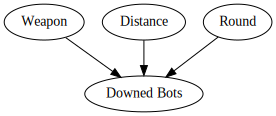

In [7]:
dag = gz.Digraph()
dag.node('w', 'Weapon')
dag.node('d', 'Distance')
dag.node('r', 'Round')
dag.node('b', 'Downed Bots')
dag.edges(['wb', 'db', 'rb'])
dag

Note that, since we randomized the experiment there is no other association between variables.

In [42]:
with pm.Model() as aim_model:
    
    # Uninformative Priors
    beta = pm.Normal('beta', mu=0, sigma=10, shape=len(values))
    round = pm.Normal('round', mu=0, sigma=10)

    # IDs
    treat_id = pm.intX(pm.ConstantData('treat_id', data['distance_weapon']))

    # Expected value of outcome
    log_odds = beta[treat_id] + round*(data['round']-1)/59
    p = pm.Deterministic('p', pm.math.invlogit(log_odds))

    # Likelihood
    bots = pm.Binomial('bots', n=N, p=p, observed=data['bots'])

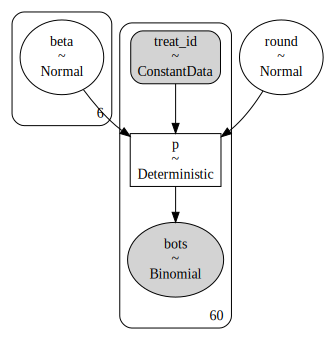

In [43]:
pm.model_to_graphviz(aim_model)

In [44]:
with aim_model:
    prior = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [beta, bots, round]


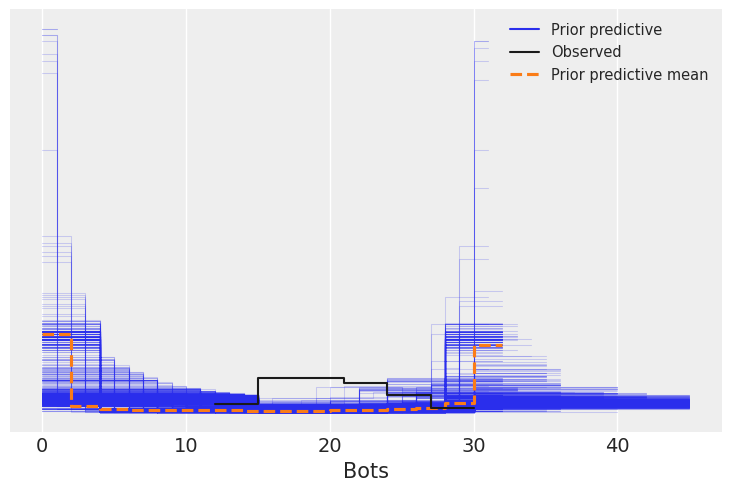

In [45]:
az.plot_ppc(prior, group='prior')
plt.xlabel('Bots')
plt.show()

In [46]:
with aim_model:
    inference_data = pm.sample()
    pm.sample_posterior_predictive(inference_data, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, round]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [bots]


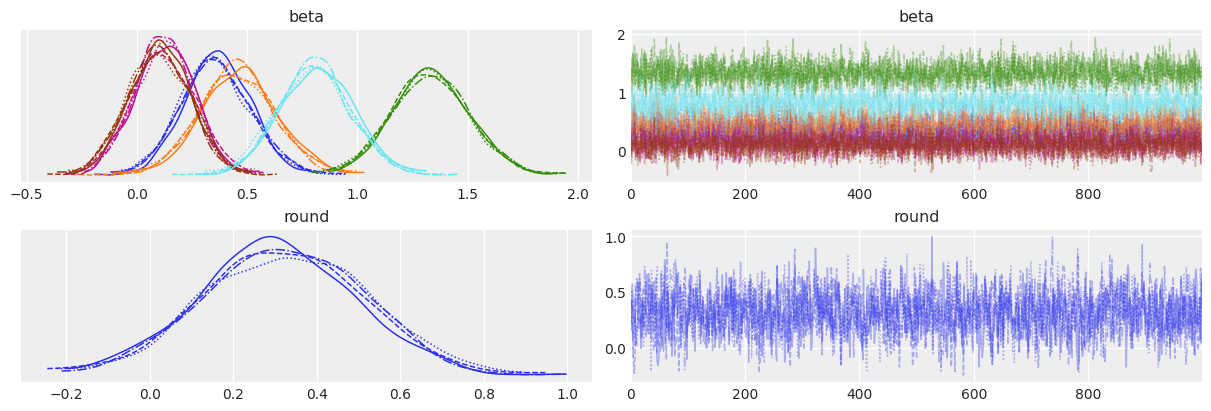

In [47]:
az.plot_trace(inference_data, var_names=['beta', 'round']);

In [48]:
az.summary(inference_data, var_names=['beta', 'round'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.36,0.16,0.08,0.67,0.0,0.0,2605.53,3034.78,1.0
beta[1],0.46,0.17,0.15,0.80,0.0,0.0,2386.74,2655.28,1.0
beta[2],1.33,0.18,1.00,1.66,0.0,0.0,2984.57,2655.23,1.0
beta[3],0.12,0.14,-0.15,0.36,0.0,0.0,3247.40,2817.59,1.0
beta[4],0.10,0.14,-0.16,0.36,0.0,0.0,2816.88,3059.12,1.0
beta[5],0.81,0.16,0.51,1.12,0.0,0.0,2507.91,3210.56,1.0
round,0.32,0.19,-0.03,0.67,0.0,0.0,1782.20,2359.85,1.0


In [14]:
az.summary(inference_data, var_names=['beta', 'round'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.36,0.15,0.07,0.63,0.0,0.0,2276.19,2969.38,1.0
beta[1],0.45,0.17,0.11,0.76,0.0,0.0,2265.43,3010.99,1.0
beta[2],1.33,0.17,1.01,1.66,0.0,0.0,2991.13,2753.23,1.0
beta[3],0.12,0.14,-0.14,0.37,0.0,0.0,3115.88,2958.42,1.0
beta[4],0.10,0.14,-0.16,0.36,0.0,0.0,3129.83,3057.03,1.0
beta[5],0.81,0.16,0.51,1.12,0.0,0.0,2635.11,2738.10,1.0
round,0.01,0.00,-0.00,0.01,0.0,0.0,1737.66,2496.82,1.0


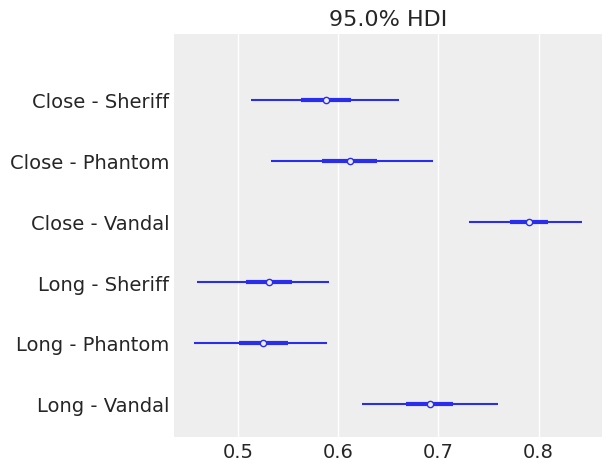

In [50]:
ax = az.plot_forest(inference_data, var_names=['beta'], transform=logistic, combined=True, hdi_prob=0.95)
ax[0].set_yticklabels(
    ['Long - Vandal',
     'Long - Phantom',
     'Long - Sheriff',
     'Close - Vandal',
     'Close - Phantom',
     'Close - Sheriff']
)
plt.show()

<Axes: xlabel='bots / bots'>

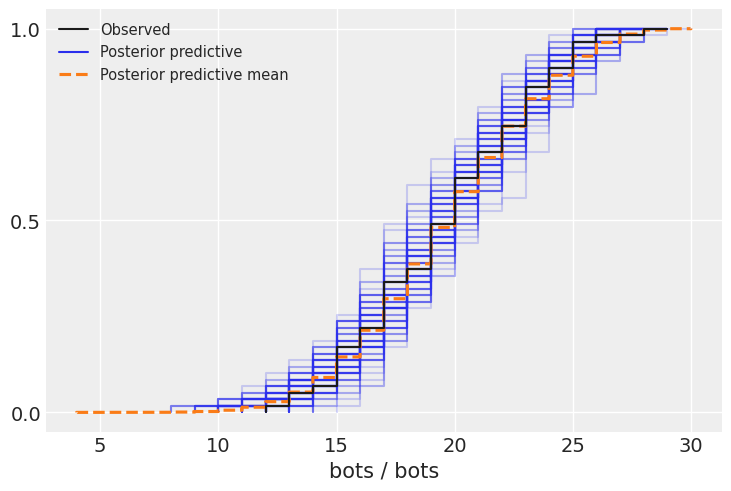

In [40]:
az.plot_ppc(inference_data, num_pp_samples=100, kind='cumulative')

### Round

In [17]:
log_odds_start = inference_data.posterior['beta'].mean(axis=2)

In [52]:
p_start = logistic(log_odds_start)
p_end = logistic(log_odds_start + 1*inference_data.posterior['round'])

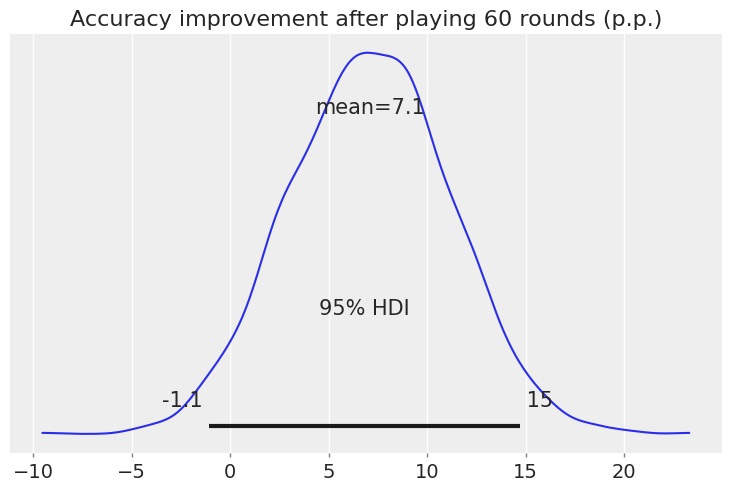

In [19]:
az.plot_posterior(100*(p_end - p_start), hdi_prob=0.95)
plt.title('Accuracy improvement after playing 60 rounds (p.p.)')
plt.show()

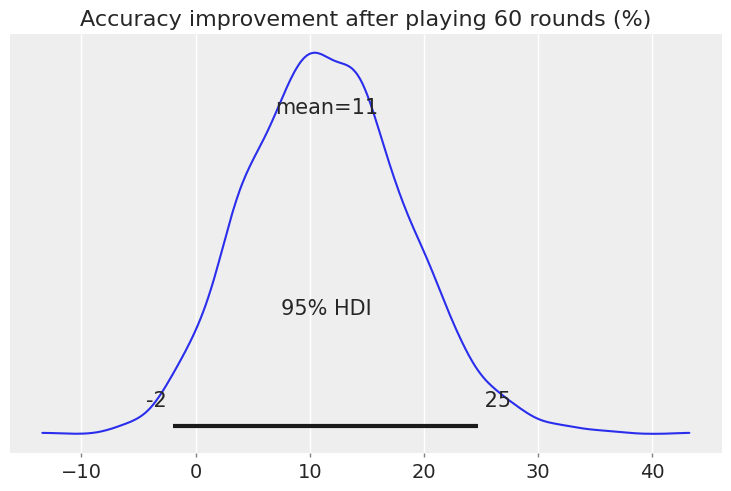

In [20]:
az.plot_posterior(100*(p_end - p_start)/p_start, hdi_prob=0.95)
plt.title('Accuracy improvement after playing 60 rounds (%)')
plt.show()

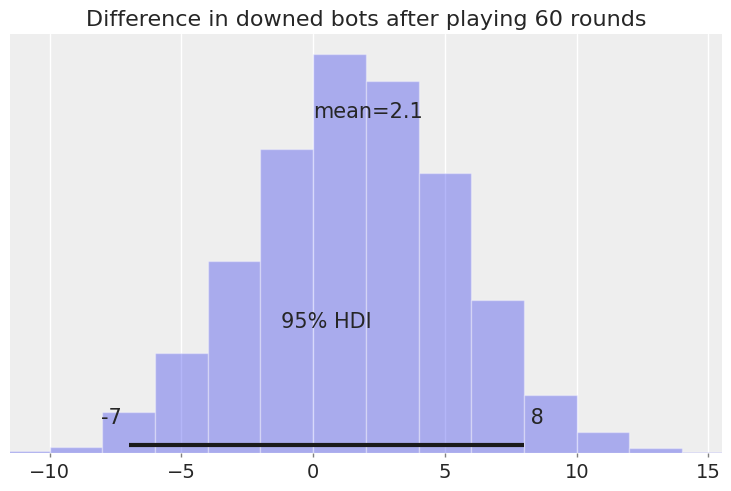

In [21]:
az.plot_posterior(np.random.binomial(N, p_end)  - np.random.binomial(N, p_start), hdi_prob=0.95)
plt.title('Difference in downed bots after playing 60 rounds')
plt.show()

### Distance

In [56]:
log_odds_close = inference_data.posterior['beta'][:, :, :3].mean(axis=2)
p_close = logistic(log_odds_close)

log_odds_long = inference_data.posterior['beta'][:, :, 3:].mean(axis=2)
p_long = logistic(log_odds_long)

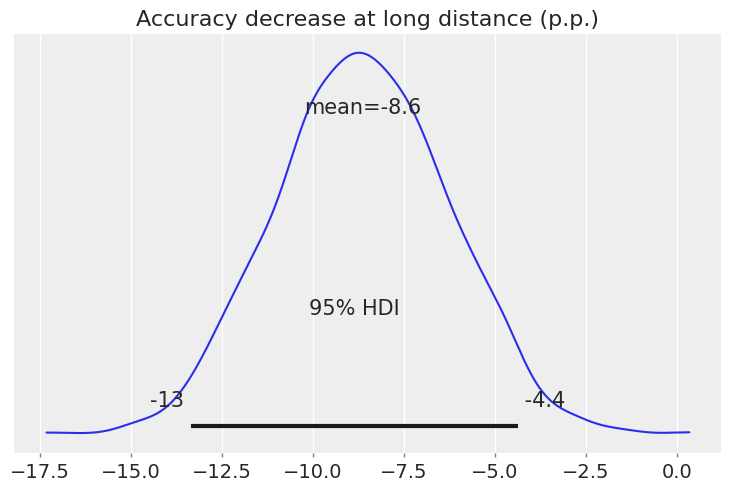

In [23]:
az.plot_posterior(100*(p_long - p_close), hdi_prob=0.95)
plt.title('Accuracy decrease at long distance (p.p.)')
plt.show()

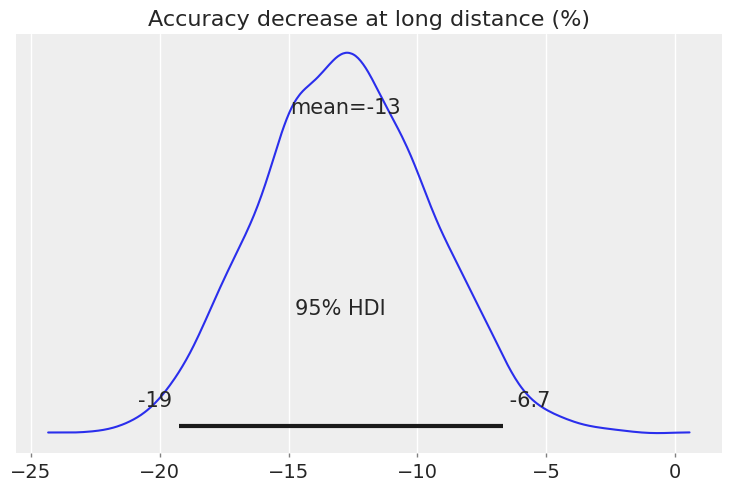

In [24]:
az.plot_posterior(100*(p_long - p_close)/p_close, hdi_prob=0.95)
plt.title('Accuracy decrease at long distance (%)')
plt.show()

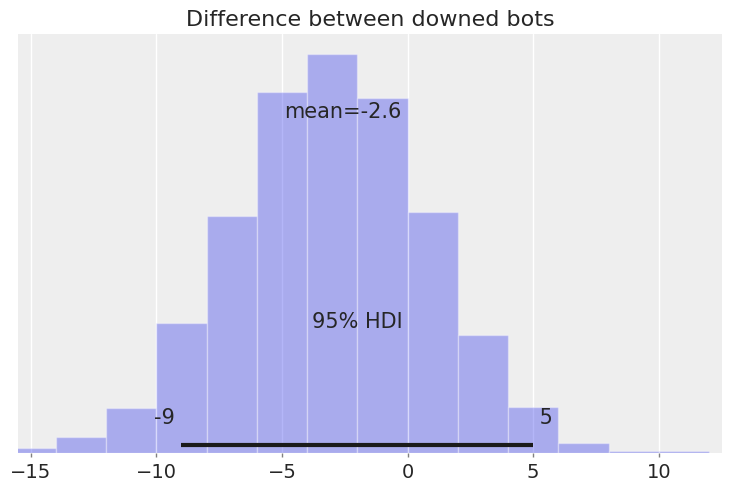

In [25]:
az.plot_posterior(np.random.binomial(N, p_long) - np.random.binomial(N, p_close), hdi_prob=0.95)
plt.title('Difference between downed bots')
plt.show()

### Weapons

#### Vandal vs Phantom

In [26]:
log_odds_phantom = inference_data.posterior['beta'][:, :, [1,4]].mean(axis=2)
p_phantom = logistic(log_odds_phantom)

log_odds_vandal = inference_data.posterior['beta'][:, :, [2,5]].mean(axis=2)
p_vandal = logistic(log_odds_vandal)

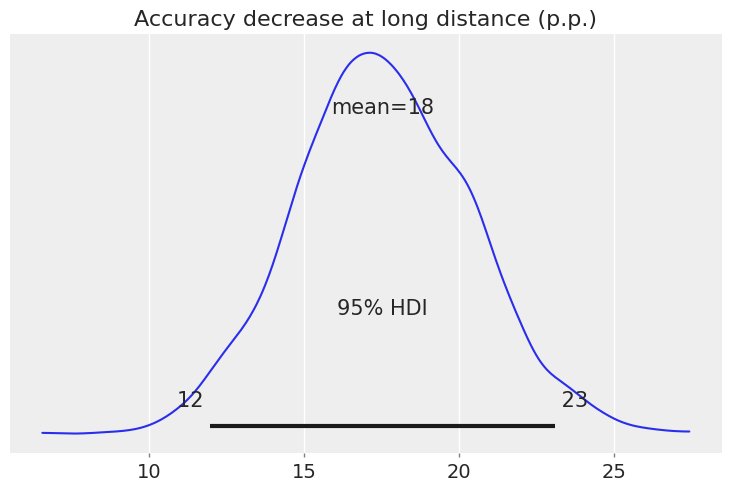

In [27]:
az.plot_posterior(100*(p_vandal - p_phantom), hdi_prob=0.95)
plt.title('Accuracy decrease at long distance (p.p.)')
plt.show()

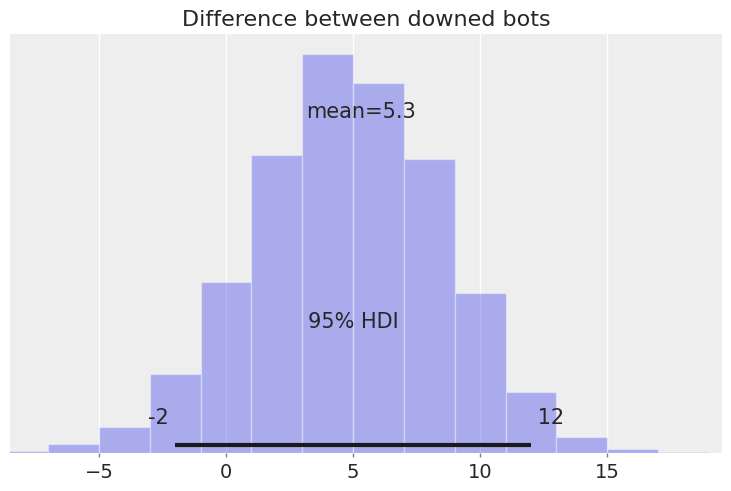

In [28]:
az.plot_posterior(np.random.binomial(N, p_vandal) - np.random.binomial(N, p_phantom), hdi_prob=0.95)
plt.title('Difference between downed bots')
plt.show()

Distribution of downed bots vandal vs phantom. Plot 4 binomial distributions

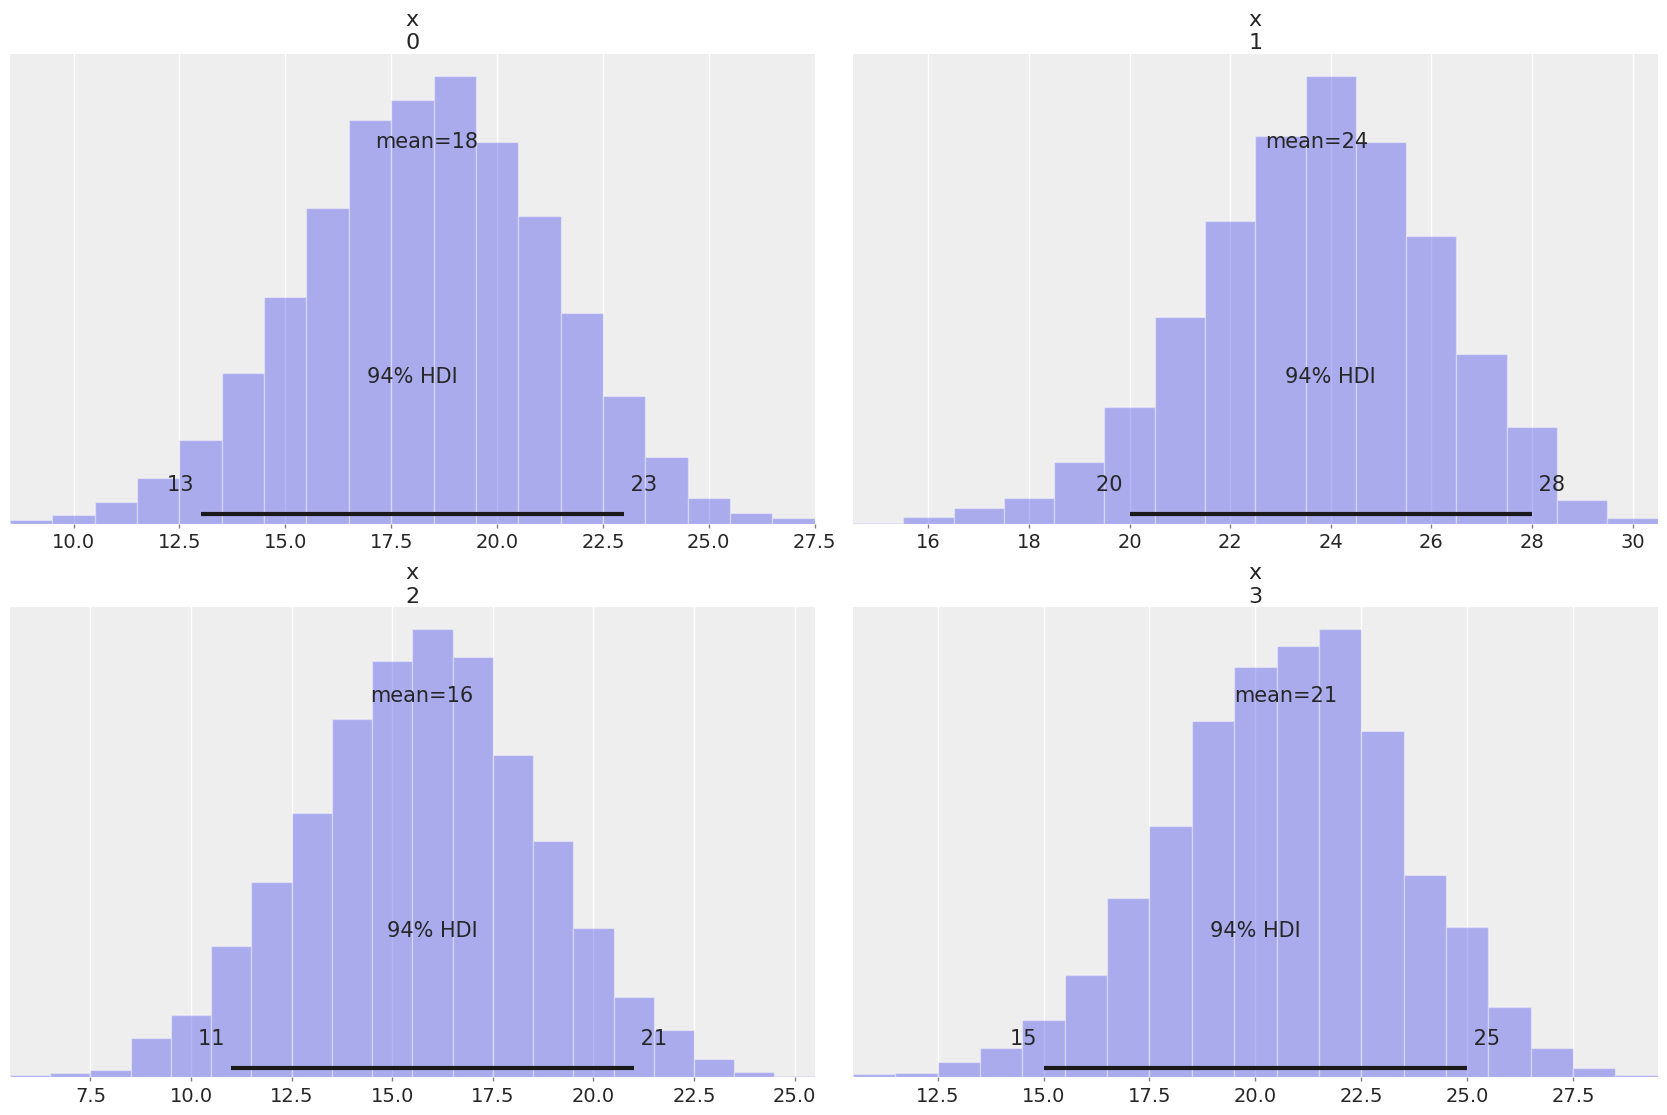

In [59]:
posteriors = np.random.binomial(N, logistic(inference_data.posterior['beta'][:, :, [1,2,4,5]]))
az.plot_posterior(posteriors, grid=(2,2))
plt.show()

In [61]:
posteriors.shape

(4, 1000, 4)

In [64]:
inference_data.posterior['beta'][:, :, [1,2,4,5]].shape

(4, 1000, 3)

<Axes: title={'center': 'x'}>

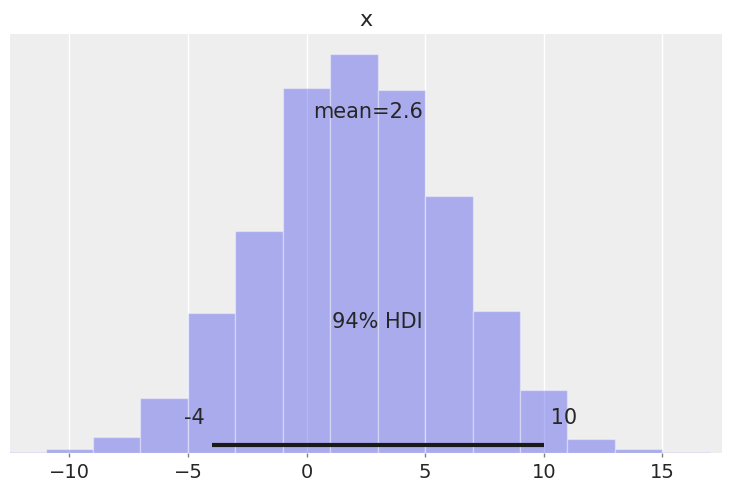

In [68]:
az.plot_posterior(posteriors[:, :, 0] - posteriors[:, :, 2]) 

<Axes: title={'center': 'x'}>

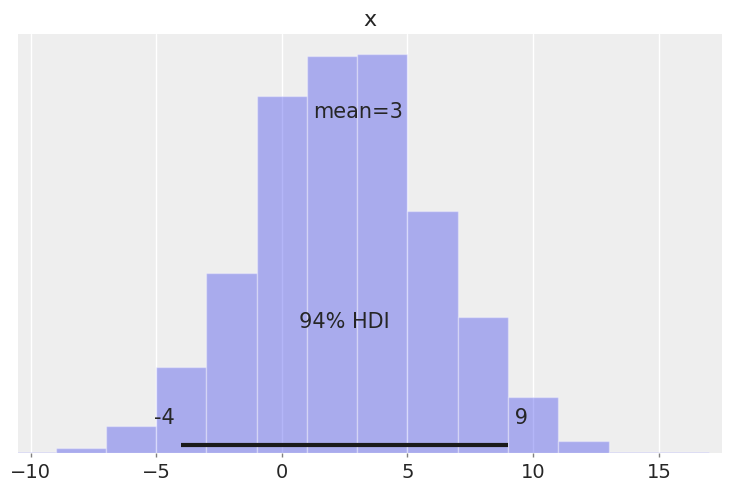

In [69]:
az.plot_posterior(posteriors[:, :, 1] - posteriors[:, :, 3] ) 